![JohnSnowLabs](https://nlp.johnsnowlabs.com/assets/images/logo.png)

In [ ]:
slides_html="""
<iframe src="https://docs.google.com/presentation/d/1wNQaCy5drc7C5R-bZWp-PA7GLef09SAOr7jCs18uibg/embed?start=true&loop=true&delayms=4000" frameborder="0" width="900" height="560" allowfullscreen="true" mozallowfullscreen="true" webkitallowfullscreen="true"></iframe>
"""
displayHTML(slides_html)

#Abstracting Real World Data from Oncology Notes: Entity Extraction
[MT ONCOLOGY NOTES](https://www.mtsamplereports.com/) comprises of millions of ehr records of patients. It contains semi-structured data like demographics, insurance details, and a lot more, but most importantly, it also contains free-text data like real encounters and notes.
Here we show how to use Spark NLP's existing models to process raw text and extract highly specialized cancer information that can be used for various downstream use cases, including:
- Staff demand analysis according to specialties.
- Preparing reimbursement-ready data with billable codes.
- Analysis of risk factors of patients and symptoms.
- Analysis of cancer disease and symptoms.
- Drug usage analysis for inventory management.
- Preparing timeline of procedures.
- Relations between internal body part and procedures.
- Analysis of procedures used on oncological events.
- Checking assertion status of oncological findings.

#0. Initial configurations

In [ ]:
import os
import json
import string
import numpy as np
import pandas as pd

import sparknlp
import sparknlp_jsl
from sparknlp.base import *
from sparknlp.util import *
from sparknlp.annotator import *
from sparknlp_jsl.base import *
from sparknlp_jsl.annotator import *
from sparknlp.pretrained import ResourceDownloader

from pyspark.sql import functions as F
from pyspark.ml import Pipeline, PipelineModel
from sparknlp.training import CoNLL

pd.set_option('max_colwidth', 100)
pd.set_option('display.max_columns', 100)  
pd.set_option('display.expand_frame_repr', False)

print('sparknlp.version : ',sparknlp.version())
print('sparknlp_jsl.version : ',sparknlp_jsl.version())

spark


sparknlp.version : 4.2.4
sparknlp_jsl.version : 4.2.4
Out[12]:

SparkSession - hive 
 
 
 SparkContext 

 Spark UI 

 
 Version 
 v3.1.2 
 Master 
 spark://10.139.64.4:7077 
 AppName 
 Databricks Shell

### Download oncology notes

In this notebook we will use the transcribed medical reports in [www.mtsamples.com](www.mtsamples.com). 

You can download those reports by the script [here](https://github.com/JohnSnowLabs/spark-nlp-workshop/blob/master/databricks/python/healthcare_case_studies/mt_scrapper.py).
    
We will use slightly modified version of some clinical notes which are downloaded from [www.mtsamples.com](www.mtsamples.com).

**Note:** We will install mlflow and "04-onco_config" file in order to download and modify the data.

In [ ]:
%pip install mlflow

In [ ]:
%run
./15-onco_config

In [ ]:
data_path = '/FileStore/HLS/nlp/data/'

ade_demo_util=SolAccUtil('onc-lh',data_path=data_path)
ade_demo_util.print_info()

base_path = /home/ahmet@johnsnowlabs.com/health-lakehouse delta_path = /home/ahmet@johnsnowlabs.com/health-lakehouse/onc-lh/delta data_path = /FileStore/HLS/nlp/data/ experiment_name = /Users/ahmet@johnsnowlabs.com/onc-lh experiment_id = 3845599403064227 artifact_location = dbfs:/databricks/mlflow-tracking/3845599403064227 tags = {'mlflow.ownerId': '3583539445967905', 'mlflow.experiment.sourceName': '/Users/ahmet@johnsnowlabs.com/onc-lh', 'mlflow.ownerEmail': 'ahmet@johnsnowlabs.com', 'mlflow.experimentType': 'MLFLOW_EXPERIMENT'}

In [ ]:
import os
data_path=ade_demo_util.settings['data_path']
os.environ['data_path']=f'/dbfs{data_path}'
delta_path=ade_demo_util.settings['delta_path']
notes_path = f'{data_path}/mt_onc_50/'

In [ ]:
%sh
cd $data_path
wget https://hls-eng-data-public.s3.amazonaws.com/data/mt_onc_50.zip
unzip -o mt_onc_50.zip

--2022-12-29 11:14:03-- https://hls-eng-data-public.s3.amazonaws.com/data/mt_onc_50.zip
Resolving hls-eng-data-public.s3.amazonaws.com (hls-eng-data-public.s3.amazonaws.com)... 52.217.94.252, 52.216.44.65, 52.217.104.36, ...
Connecting to hls-eng-data-public.s3.amazonaws.com (hls-eng-data-public.s3.amazonaws.com)|52.217.94.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 93586 (91K) [application/zip]
Saving to: ‘mt_onc_50.zip.33’

 0K .......... .......... .......... .......... .......... 54% 7.50M 0s
 50K .......... .......... .......... .......... . 100% 10.1M=0.01s

2022-12-29 11:14:04 (8.48 MB/s) - ‘mt_onc_50.zip.33’ saved [93586/93586]

Archive: mt_onc_50.zip
 inflating: mt_onc_50/mt_oncology_0.txt 
 inflating: mt_onc_50/mt_oncology_1.txt 
 inflating: mt_onc_50/mt_oncology_10.txt 
 inflating: mt_onc_50/mt_oncology_11.txt 
 inflating: mt_onc_50/mt_oncology_12.txt 
 inflating: mt_onc_50/mt_oncology_13.txt 
 inflating: mt_onc_50/mt_oncology_14.txt 
 inflating: mt_onc_50/mt_oncology_15.txt 
 inflating: mt_onc_50/mt_oncology_16.txt 
 inflating: mt_onc_50/mt_oncology_17.txt 
 inflating: mt_onc_50/mt_oncology_18.txt 
 inflating: mt_onc_50/mt_oncology_19.txt 
 inflating: mt_onc_50/mt_oncology_2.txt 
 inflating: mt_onc_50/mt_oncology_20.txt 
 inflating: mt_onc_50/mt_oncology_21.txt 
 inflating: mt_onc_50/mt_oncology_22.txt 
 inflating: mt_onc_50/mt_oncology_23.txt 
 inflating: mt_onc_50/mt_oncology_24.txt 
 inflating: mt_onc_50/mt_oncology_25.txt 
 inflating: mt_onc_50/mt_oncology_26.txt 
 inflating: mt_onc_50/mt_oncology_27.txt 
 inflating: mt_onc_50/mt_oncology_28.txt 
 inflating: mt_onc_50/mt_oncology_29.txt 
 inflating: mt_onc_50/mt_oncology_3.txt 
 inflating: mt_onc_50/mt_oncology_30.txt 
 inflating: mt_onc_50/mt_oncology_31.txt 
 inflating: mt_onc_50/mt_oncology_32.txt 
 inflating: mt_onc_50/mt_oncology_33.txt 
 inflating: mt_onc_50/mt_oncology_34.txt 
 inflating: mt_onc_50/mt_oncology_35.txt 
 inflating: mt_onc_50/mt_oncology_36.txt 
 inflating: mt_onc_50/mt_oncology_37.txt 
 inflating: mt_onc_50/mt_oncology_38.txt 
 inflating: mt_onc_50/mt_oncology_39.txt 
 inflating: mt_onc_50/mt_oncology_4.txt 
 inflating: mt_onc_50/mt_oncology_40.txt 
 inflating: mt_onc_50/mt_oncology_41.txt 
 inflating: mt_onc_50/mt_oncology_42.txt 
 inflating: mt_onc_50/mt_oncology_43.txt 
 inflating: mt_onc_50/mt_oncology_44.txt 
 inflating: mt_onc_50/mt_oncology_45.txt 
 inflating: mt_onc_50/mt_oncology_46.txt 
 inflating: mt_onc_50/mt_oncology_47.txt 
 inflating: mt_onc_50/mt_oncology_48.txt 
 inflating: mt_onc_50/mt_oncology_49.txt 
 inflating: mt_onc_50/mt_oncology_5.txt 
 inflating: mt_onc_50/mt_oncology_6.txt 
 inflating: mt_onc_50/mt_oncology_7.txt 
 inflating: mt_onc_50/mt_oncology_8.txt 
 inflating: mt_onc_50/mt_oncology_9.txt

In [ ]:
display(dbutils.fs.ls(notes_path),10)

path,name,size
dbfs:/FileStore/HLS/nlp/data/mt_onc_50/mt_oncology_0.txt,mt_oncology_0.txt,5471
dbfs:/FileStore/HLS/nlp/data/mt_onc_50/mt_oncology_1.txt,mt_oncology_1.txt,3241
dbfs:/FileStore/HLS/nlp/data/mt_onc_50/mt_oncology_10.txt,mt_oncology_10.txt,4291
dbfs:/FileStore/HLS/nlp/data/mt_onc_50/mt_oncology_11.txt,mt_oncology_11.txt,2058
dbfs:/FileStore/HLS/nlp/data/mt_onc_50/mt_oncology_12.txt,mt_oncology_12.txt,3405
dbfs:/FileStore/HLS/nlp/data/mt_onc_50/mt_oncology_13.txt,mt_oncology_13.txt,1561
dbfs:/FileStore/HLS/nlp/data/mt_onc_50/mt_oncology_14.txt,mt_oncology_14.txt,2555
dbfs:/FileStore/HLS/nlp/data/mt_onc_50/mt_oncology_15.txt,mt_oncology_15.txt,9395
dbfs:/FileStore/HLS/nlp/data/mt_onc_50/mt_oncology_16.txt,mt_oncology_16.txt,2096
dbfs:/FileStore/HLS/nlp/data/mt_onc_50/mt_oncology_17.txt,mt_oncology_17.txt,1992


### Read Data and Write to Bronze Delta Layer

There are 50 clinical notes stored in delta table. We read the data nd write the raw notes data into bronze delta tables

In [ ]:
df = sc.wholeTextFiles(notes_path).toDF().withColumnRenamed('_1','path').withColumnRenamed('_2','text')
display(df.limit(5))

path text dbfs:/FileStore/HLS/nlp/data/mt_onc_50/mt_oncology_0.txt Sample Type / Medical Specialty:
Hematology - Oncology
Sample Name:
Discharge Summary - Mesothelioma - 1
Description:
Mesothelioma, pleural effusion, atrial fibrillation, anemia, ascites, esophageal reflux, and history of deep venous thrombosis.
(Medical Transcription Sample Report)
PRINCIPAL DIAGNOSIS:
Mesothelioma.
SECONDARY DIAGNOSES:
Pleural effusion, atrial fibrillation, anemia, ascites, esophageal reflux, and history of deep venous thrombosis.
PROCEDURES
1. On August 24, 2007, decortication of the lung with pleural biopsy and transpleural fluoroscopy.
2. On August 20, 2007, thoracentesis.
3. On August 31, 2007, Port-A-Cath placement.
HISTORY AND PHYSICAL:
The patient is a 41-year-old Vietnamese female with a nonproductive cough that started last week. She has had right-sided chest pain radiating to her back with fever starting yesterday. She has a history of pericarditis and pericardectomy in May 2006 and developed cough with right-sided chest pain, and went to an urgent care center. Chest x-ray revealed right-sided pleural effusion.
PAST MEDICAL HISTORY
1. Pericardectomy.
2. Pericarditis.
2. Atrial fibrillation.
4. RNCA with intracranial thrombolytic treatment.
5 PTA of MCA.
6. Mesenteric venous thrombosis.
7. Pericardial window.
8. Cholecystectomy.
9. Left thoracentesis.
FAMILY HISTORY:
No family history of coronary artery disease, CVA, diabetes, CHF or MI. The patient has one family member, a sister, with history of cancer.
SOCIAL HISTORY:
She is married. Employed with the US Post Office. She is a mother of three. Denies tobacco, alcohol or illicit drug use.
MEDICATIONS
1. Coumadin 1 mg daily. Last INR was on Tuesday, August 14, 2007, and her INR was 2.3.
2. Amiodarone 100 mg p.o. daily.
REVIEW OF SYSTEMS:
Complete review of systems negative except as in pulmonary as noted above. The patient also reports occasional numbness and tingling of her left arm.
PHYSICAL EXAMINATION
VITAL SIGNS: Blood pressure 123/95, heart rate 83, respirations 20, temperature 97, and oxygen saturation 97%.
GENERAL: Positive nonproductive cough and pain with coughing.
HEENT: Pupils are equal and reactive to light and accommodation. Tympanic membranes are clear.
NECK: Supple. No lymphadenopathy. No masses.
RESPIRATORY: Pleural friction rub is noted.
GI: Soft, nondistended, and nontender. Positive bowel sounds. No organomegaly.
EXTREMITIES: No edema, no clubbing, no cyanosis, no tenderness. Full range of motion. Normal pulses in all extremities.
SKIN: No breakdown or lesions. No ulcers.
NEUROLOGIC: Grossly intact. No focal deficits. Awake, alert, and oriented to person, place, and time.
LABORATORY DATA:
Labs are pending.
HOSPITAL COURSE:
The patient was admitted for a right-sided pleural effusion for thoracentesis on Monday by Dr. X. Her Coumadin was placed on hold. A repeat echocardiogram was checked. She was started on prophylaxis for DVT with Lovenox 40 mg subcutaneously. Her history dated back to March 2005 when she first sought medical attention for evidence of pericarditis, which was treated with pericardial window in an outside hospital, at that time she was also found to have mesenteric pain and thrombosis, is now anticoagulated. Her pericardial fluid was accumulated and she was seen by Dr. Y. At that time, she was recommended for pericardectomy, which was performed by Dr. Z. Review of her CT scan from March 2006 prior to her pericardectomy, already shows bilateral plural effusions. The patient improved clinically after the pericardectomy with resolution of her symptoms. Recently, she was readmitted to the hospital with chest pain and found to have bilateral pleural effusion, the right greater than the left. CT of the chest also revealed a large mediastinal lymph node. We reviewed the pathology obtained from the pericardectomy in March 2006, which was diagnostic of mesothelioma. At this time, chest tube placement for drainage of the fluid occurred and thoracoscopy with f

In [ ]:
df.count()

Out[8]: 50

In [ ]:
df.write.format('delta').mode('overwrite').save(f'{delta_path}/bronze/mt-oc-notes')
display(dbutils.fs.ls(f'{delta_path}/bronze/mt-oc-notes'))

path,name,size
dbfs:/home/ahmet@johnsnowlabs.com/health-lakehouse/onc-lh/delta/bronze/mt-oc-notes/_delta_log/,_delta_log/,0
dbfs:/home/ahmet@johnsnowlabs.com/health-lakehouse/onc-lh/delta/bronze/mt-oc-notes/part-00000-2e22fab3-4b8e-4870-9b90-5c515b42af5a-c000.snappy.parquet,part-00000-2e22fab3-4b8e-4870-9b90-5c515b42af5a-c000.snappy.parquet,51598
dbfs:/home/ahmet@johnsnowlabs.com/health-lakehouse/onc-lh/delta/bronze/mt-oc-notes/part-00000-3ad61670-2fb5-4010-8b96-a4fc39484951-c000.snappy.parquet,part-00000-3ad61670-2fb5-4010-8b96-a4fc39484951-c000.snappy.parquet,51598
dbfs:/home/ahmet@johnsnowlabs.com/health-lakehouse/onc-lh/delta/bronze/mt-oc-notes/part-00000-4f1f8064-8772-48fb-8b88-2591bf3204e7-c000.snappy.parquet,part-00000-4f1f8064-8772-48fb-8b88-2591bf3204e7-c000.snappy.parquet,51598
dbfs:/home/ahmet@johnsnowlabs.com/health-lakehouse/onc-lh/delta/bronze/mt-oc-notes/part-00000-5dd510a4-b70f-45bb-8b23-e7bc2d993563-c000.snappy.parquet,part-00000-5dd510a4-b70f-45bb-8b23-e7bc2d993563-c000.snappy.parquet,51598
dbfs:/home/ahmet@johnsnowlabs.com/health-lakehouse/onc-lh/delta/bronze/mt-oc-notes/part-00000-aaeaee39-c8b8-4f57-8672-e48106ee2122-c000.snappy.parquet,part-00000-aaeaee39-c8b8-4f57-8672-e48106ee2122-c000.snappy.parquet,51598
dbfs:/home/ahmet@johnsnowlabs.com/health-lakehouse/onc-lh/delta/bronze/mt-oc-notes/part-00001-14d180fd-6331-41d6-bb72-071f6c421d26-c000.snappy.parquet,part-00001-14d180fd-6331-41d6-bb72-071f6c421d26-c000.snappy.parquet,51288
dbfs:/home/ahmet@johnsnowlabs.com/health-lakehouse/onc-lh/delta/bronze/mt-oc-notes/part-00001-a3cea322-a6eb-423f-a5c5-30ba065caf89-c000.snappy.parquet,part-00001-a3cea322-a6eb-423f-a5c5-30ba065caf89-c000.snappy.parquet,51288
dbfs:/home/ahmet@johnsnowlabs.com/health-lakehouse/onc-lh/delta/bronze/mt-oc-notes/part-00001-a775776d-7da5-49d6-9689-cfe5c1556892-c000.snappy.parquet,part-00001-a775776d-7da5-49d6-9689-cfe5c1556892-c000.snappy.parquet,51288
dbfs:/home/ahmet@johnsnowlabs.com/health-lakehouse/onc-lh/delta/bronze/mt-oc-notes/part-00001-b8e956d5-7ec5-4f6d-80de-6418581b28bf-c000.snappy.parquet,part-00001-b8e956d5-7ec5-4f6d-80de-6418581b28bf-c000.snappy.parquet,51288


In [ ]:
sample_text = df.limit(1).select("text").collect()[0]

## Setup initial NLP pipelines and stages
First let's define all stages that are common among all downstream pipelines

In [ ]:
documentAssembler = DocumentAssembler()\
  .setInputCol("text")\
  .setOutputCol("document")

documentAssemblerResolver = DocumentAssembler()\
  .setInputCol("text")\
  .setOutputCol("ner_chunks")

sentenceDetector = SentenceDetectorDLModel.pretrained("sentence_detector_dl_healthcare","en","clinical/models") \
  .setInputCols(["document"]) \
  .setOutputCol("sentence")

tokenizer = Tokenizer()\
  .setInputCols(["sentence"])\
  .setOutputCol("token")

word_embeddings = WordEmbeddingsModel.pretrained("embeddings_clinical", "en", "clinical/models")\
  .setInputCols(["sentence", "token"])\
  .setOutputCol("embeddings")


sentence_detector_dl_healthcare download started this may take some time.
Approximate size to download 367.3 KB
[ | ][OK!]
embeddings_clinical download started this may take some time.
Approximate size to download 1.6 GB
[ | ][OK!]

In [ ]:
base_stages = [
        documentAssembler,
        sentenceDetector,
        tokenizer,
        word_embeddings
]

## Visualize the Entities Using Spark NLP Display Library

At first, we will create a NER pipeline. And then, we can see the labbeled entities on text.

In [ ]:
# Cancer
bionlp_ner = MedicalNerModel.pretrained("ner_bionlp", "en", "clinical/models") \
  .setInputCols(["sentence", "token", "embeddings"]) \
  .setOutputCol("bionlp_ner")\
  .setBatchSize(128)\
  .setIncludeConfidence(False)

bionlp_ner_converter = NerConverterInternal() \
  .setInputCols(["sentence", "token", "bionlp_ner"]) \
  .setOutputCol("bionlp_ner_chunk")\
  .setWhiteList(["Cancer"])

# Clinical Terminology
jsl_ner = MedicalNerModel.pretrained("ner_jsl", "en", "clinical/models") \
  .setInputCols(["sentence", "token", "embeddings"]) \
  .setOutputCol("jsl_ner")\
  .setBatchSize(128)\
  .setIncludeConfidence(False)

jsl_ner_converter = NerConverterInternal() \
  .setInputCols(["sentence", "token", "jsl_ner"]) \
  .setOutputCol("jsl_ner_chunk")\
  .setWhiteList(["Oncological", "Symptom", "Treatment"])

We used two diferent NER models (`ner_jsl` and `bionlp_ner`) and we need to merge them by a chunk merger. There are two different entities related to oncology. So we will change `Cancer` entities to `Oncological` by `setReplaceDictResource` parameter. This parameter gets the list from a csv file. Before merging the entities, we are creating the csv file with a row `Cancer,Oncological`.

In [ ]:
dbutils.fs.put('/tmp/replace_dict.csv','Cancer,Oncological',overwrite=True)

chunk_merger = ChunkMergeApproach()\
  .setInputCols("bionlp_ner_chunk","jsl_ner_chunk")\
  .setOutputCol("final_ner_chunk")\
  .setReplaceDictResource('/tmp/replace_dict.csv',"text", {"delimiter":","})

ner_pipeline= Pipeline(
                        stages = base_stages+[
                            bionlp_ner,
                            bionlp_ner_converter,
                            jsl_ner,
                            jsl_ner_converter,
                            chunk_merger]
)

empty_data = spark.createDataFrame([['']]).toDF("text")
ner_model = ner_pipeline.fit(empty_data)

Wrote 18 bytes.

Now we will visualize a sample text with `NerVisualizer`. Since `NerVisualizer` woks with Lightpipeline, so we will create a `light_model` with our `ner_model_model`.

In [ ]:
light_model =  LightPipeline(ner_model)
ann_text = light_model.fullAnnotate(sample_text.text)[0]
ann_text.keys()

Out[19]: dict_keys(['document', 'final_ner_chunk', 'jsl_ner_chunk', 'bionlp_ner', 'jsl_ner', 'token', 'embeddings', 'sentence', 'bionlp_ner_chunk'])

In [ ]:
from sparknlp_display import NerVisualizer

visualiser = NerVisualizer()

# Change color of an entity label
visualiser.set_label_colors({'ONCOLOGICAL':'#ff2e51', 'TREATMENT': '#3bdeff', 'SYMPTOM': '#00ff40' })

ner_vis = visualiser.display(ann_text, label_col='final_ner_chunk',return_html=True)

displayHTML(ner_vis)

Sample Type / Medical Specialty: Hematology - Oncology Sample Name: Discharge Summary - Mesothelioma Oncological - 1 Description: Mesothelioma Oncological , pleural effusion, atrial fibrillation, anemia, ascites, esophageal reflux, and history of deep venous thrombosis. (Medical Transcription Sample Report) PRINCIPAL DIAGNOSIS: Mesothelioma Oncological . SECONDARY DIAGNOSES: Pleural effusion, atrial fibrillation, anemia, ascites, esophageal reflux, and history of deep venous thrombosis. PROCEDURES 1. On August 24, 2007, decortication of the lung with pleural biopsy and transpleural fluoroscopy. 2. On August 20, 2007, thoracentesis. 3. On August 31, 2007, Port-A-Cath placement. HISTORY AND PHYSICAL: The patient is a 41-year-old Vietnamese female with a nonproductive cough Symptom that started last week. She has had right-sided chest pain Symptom radiating to her back with fever starting yesterday. She has a history of pericarditis and pericardectomy in May 2006 and developed cough Symptom with right-sided chest pain Symptom , and went to an urgent care center. Chest x-ray revealed right-sided pleural effusion. PAST MEDICAL HISTORY 1. Pericardectomy. 2. Pericarditis. 2. Atrial fibrillation. 4. RNCA with intracranial thrombolytic treatment. 5 PTA of MCA. 6. Mesenteric venous thrombosis. 7. Pericardial window. 8. Cholecystectomy. 9. Left thoracentesis. FAMILY HISTORY: No family history of coronary artery disease, CVA, diabetes, CHF or MI. The patient has one family member, a sister, with history of cancer Oncological . SOCIAL HISTORY: She is married. Employed with the US Post Office. She is a mother of three. Denies tobacco, alcohol or illicit drug use. MEDICATIONS 1. Coumadin 1 mg daily. Last INR was on Tuesday, August 14, 2007, and her INR was 2.3. 2. Amiodarone 100 mg p.o. daily. REVIEW OF SYSTEMS: Complete review of systems negative except as in pulmonary as noted above. The patient also reports occasional numbness Symptom and tingling of her left arm Symptom . PHYSICAL EXAMINATION VITAL SIGNS: Blood pressure 123/95, heart rate 83, respirations 20, temperature 97, and oxygen saturation 97%. GENERAL: Positive nonproductive cough Symptom and pain Symptom with coughing Symptom . HEENT: Pupils are equal and reactive to light and accommodation. Tympanic membranes are clear. NECK: Supple. No lymphadenopathy Symptom . No masses Symptom . RESPIRATORY: Pleural friction rub Symptom is noted. GI: Soft, nondistended, and nontender Symptom . Positive bowel sounds. No organomegaly Symptom . EXTREMITIES: No edema Symptom , no clubbing Symptom , no cyanosis, no tenderness Symptom . Full range of motion. Normal pulses in all extremities. SKIN: No breakdown Symptom or lesions Symptom . No ulcers Symptom . NEUROLOGIC: Grossly intact. No focal deficits Symptom . Awake, alert, and oriented to person, place, and time. LABORATORY DATA: Labs are pending. HOSPITAL COURSE: The patient was admitted for a right-sided pleural effusion for thoracentesis on Monday by Dr. X. Her Coumadin was placed on hold. A repeat echocardiogram was checked. She was started on prophylaxis for DVT with Lovenox 40 mg subcutaneously. Her history dated back to March 2005 when she first sought medical attention for evidence of pericarditis, which was treated with pericardial window in an outside hospital, at that time she was also found to have mesenteric pain Symptom and thrombosis, is now anticoagulated. Her pericardial fluid was accumulated and she was seen by Dr. Y. At that time, she was recommended for pericardectomy, which was performed by Dr. Z. Review of her CT scan from March 2006 prior to her pericardectomy, already shows bilateral plural effusions. The patient improved clinically after the pericardectomy with resolution of her symptoms. Recently, she was readmitted to the hospital with chest pain Symptom and found to have bilateral pleural effusion, the right greater than the left. CT of the chest also revealed a large mediastinal lymph node Symptom . We reviewed the

# 1. ICD-10 code extraction
In this step we get ICD-10 codes using entity resolvers and use the data for various use cases.
We can use `hcc_billable` entity resolver to get ICD10-CM codes for identified entities. The unique this about this resolver is it also provides HCC risk factor and billable status for each ICD code. We can use this information for a lot of tasks.

Now we will transform our dataframe by using `ner_model` that we already created, and then we will get the `ner_chunks` into a list to use for the resolver LightPipeline.

In [ ]:
ner_res = ner_model.transform(df)

Optionally we can also store `ner_res` data into the broze delta laeyer for future accesibility

In [ ]:
ner_res.repartition('path').write.format('delta').mode('overwrite').save(f'{delta_path}/bronze/ner-res-notes')

In [ ]:
ner_pdf = ner_res.select("path", F.explode(F.arrays_zip(ner_res.final_ner_chunk.result, 
                                                       ner_res.final_ner_chunk.metadata)).alias("cols"))\
                .select("path", F.expr("cols['0']").alias("final_chunk"), 
                                F.expr("cols['1']['entity']").alias("entity"))\
                .toPandas()

ner_chunks = list(ner_pdf.final_chunk)
display(ner_pdf)

/databricks/spark/python/pyspark/sql/pandas/conversion.py:499: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
 arrow_data = [[(c, t) for (_, c), t in zip(pdf_slice.iteritems(), arrow_types)]

path,final_chunk,entity
dbfs:/FileStore/HLS/nlp/data/mt_onc_50/mt_oncology_0.txt,Mesothelioma,Oncological
dbfs:/FileStore/HLS/nlp/data/mt_onc_50/mt_oncology_0.txt,Mesothelioma,Oncological
dbfs:/FileStore/HLS/nlp/data/mt_onc_50/mt_oncology_0.txt,Mesothelioma,Oncological
dbfs:/FileStore/HLS/nlp/data/mt_onc_50/mt_oncology_0.txt,cough,Symptom
dbfs:/FileStore/HLS/nlp/data/mt_onc_50/mt_oncology_0.txt,chest pain,Symptom
dbfs:/FileStore/HLS/nlp/data/mt_onc_50/mt_oncology_0.txt,cough,Symptom
dbfs:/FileStore/HLS/nlp/data/mt_onc_50/mt_oncology_0.txt,chest pain,Symptom
dbfs:/FileStore/HLS/nlp/data/mt_onc_50/mt_oncology_0.txt,cancer,Oncological
dbfs:/FileStore/HLS/nlp/data/mt_onc_50/mt_oncology_0.txt,numbness,Symptom
dbfs:/FileStore/HLS/nlp/data/mt_onc_50/mt_oncology_0.txt,tingling of her left arm,Symptom


We are creating resolver PipelineModel with `document_assembler`, `sbert_jsl_medium_uncased` embedding and `sbertresolve_icd10cm_slim_billable_hcc_med` resolver.

In [ ]:
sbert_embedder = BertSentenceEmbeddings.pretrained("sbert_jsl_medium_uncased", 'en', 'clinical/models')\
  .setInputCols(["ner_chunks"])\
  .setOutputCol("sentence_embeddings")

icd10_resolver = SentenceEntityResolverModel.pretrained("sbertresolve_icd10cm_slim_billable_hcc_med","en", "clinical/models")\
  .setInputCols(["sentence_embeddings"]) \
  .setOutputCol("icd10_code")\
  .setDistanceFunction("EUCLIDEAN")

icd_pipelineModel = PipelineModel(stages=[
            documentAssemblerResolver,
            sbert_embedder,
            icd10_resolver
            ])

sbert_jsl_medium_uncased download started this may take some time.
Approximate size to download 146.8 MB
[ | ][OK!]
sbertresolve_icd10cm_slim_billable_hcc_med download started this may take some time.
[ | ][OK!]

In [ ]:
icd10_hcc_lp = LightPipeline(icd_pipelineModel)
icd10_hcc_result = icd10_hcc_lp.fullAnnotate(ner_chunks)

Now we will create a pandas dataframe to show the results obviously. We will walk on the `icd10_hcc_result` line by line and take icd10 code (`icd10_code`), confidence levels (`confidence`), all possible codes (`all_k_results`), resolutions of the all possible codes (`all_k_resolutions`) and HCC details (`all_k_aux_labels`) of the icd10 code.

In [ ]:
tuples = []

for i in range(len(icd10_hcc_result)):
    for x,y in zip(icd10_hcc_result[i]["ner_chunks"], icd10_hcc_result[i]["icd10_code"]):
        tuples.append((ner_pdf.path.iloc[i],x.result, ner_pdf.entity.iloc[i], y.result, y.metadata["confidence"], y.metadata["all_k_results"], y.metadata["all_k_resolutions"], y.metadata["all_k_aux_labels"]))

icd10_hcc_pdf = pd.DataFrame(tuples, columns=["path", "final_chunk", "entity", "icd10_code", "confidence", "all_codes", "resolutions", "hcc_list"])


codes = []
resolutions = []
hcc_all = []

for code, resolution, hcc in zip(icd10_hcc_pdf['all_codes'], icd10_hcc_pdf['resolutions'], icd10_hcc_pdf['hcc_list']):
    
    codes.append( code.split(':::'))
    resolutions.append(resolution.split(':::'))
    hcc_all.append(hcc.split(":::"))

icd10_hcc_pdf['all_codes'] = codes  
icd10_hcc_pdf['resolutions'] = resolutions
icd10_hcc_pdf['hcc_list'] = hcc_all

The values in `billable`, `hcc_store` and `hcc_status` columns are seperated by `||` and we will change them to a list.

In [ ]:
def extract_billable(bil):
  
  billable = []
  status = []
  score = []

  for b in bil:
    billable.append(b.split("||")[0])
    status.append(b.split("||")[1])
    score.append(b.split("||")[2])

  return (billable, status, score)

icd10_hcc_pdf["hcc_status"] = icd10_hcc_pdf["hcc_list"].apply(extract_billable).apply(pd.Series).iloc[:,1]
icd10_hcc_pdf["hcc_score"] = icd10_hcc_pdf["hcc_list"].apply(extract_billable).apply(pd.Series).iloc[:,2]
icd10_hcc_pdf["billable"] = icd10_hcc_pdf["hcc_list"].apply(extract_billable).apply(pd.Series).iloc[:,0]

icd10_hcc_pdf.drop("hcc_list", axis=1, inplace= True)
icd10_hcc_pdf['icd_codes_names'] = icd10_hcc_pdf['resolutions'].apply(lambda x : x[0].split("[")[0])
icd10_hcc_pdf['icd_code_billable'] = icd10_hcc_pdf['billable'].apply(lambda x : x[0])

### Write `icd10_hcc_df` to Delta
Now we proceed to write resolved ICD10 codes which also contain information regarding HCC status corresponding to each code as one of the silver delta tables in our clinical lakehouse

In [ ]:
icd10_hcc_df = spark.createDataFrame(icd10_hcc_pdf)
icd10_hcc_df.write.format('delta').mode('overwrite').save(f'{delta_path}/silver/icd10-hcc-df')

/databricks/spark/python/pyspark/sql/pandas/conversion.py:499: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
 arrow_data = [[(c, t) for (_, c), t in zip(pdf_slice.iteritems(), arrow_types)]

In [ ]:
display(icd10_hcc_df.limit(10))

path,final_chunk,entity,icd10_code,confidence,all_codes,resolutions,hcc_status,hcc_score,billable,icd_codes_names,icd_code_billable
dbfs:/FileStore/HLS/nlp/data/mt_onc_50/mt_oncology_0.txt,Mesothelioma,Oncological,C45,0.9986,"List(C45, C450, C459, C452, C457, C451, G731, C439, D165, C717, C649, C710, D352, C9000, C900)","List(mesothelioma [Mesothelioma], mesothelioma of pleura [Mesothelioma of pleura], mesothelioma, unspecified [Mesothelioma, unspecified], mesothelioma of pericardium [Mesothelioma of pericardium], mesothelioma of other sites [Mesothelioma of other sites], mesothelioma of mesentery [Mesothelioma of peritoneum], cancer, mesothelioma [Lambert-Eaton syndrome in neoplastic disease], amelanotic melanoma [Malignant melanoma of skin, unspecified], ameloblastoma of mandible [Benign neoplasm of lower jaw bone], glioma of brainstem [Malignant neoplasm of brain stem], nephroblastoma [Malignant neoplasm of unspecified kidney, except renal pelvis], glioblastoma multiforme, cerebrum [Malignant neoplasm of cerebrum, except lobes and ventricles], pituitary microadenoma [Benign neoplasm of pituitary gland], smoldering myeloma [Multiple myeloma not having achieved remission], smoldering myeloma [Multiple myeloma])","List(0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0)","List(0, 9, 9, 9, 9, 9, 75, 12, 0, 10, 11, 10, 12, 9, 0)","List(0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0)",mesothelioma,0
dbfs:/FileStore/HLS/nlp/data/mt_onc_50/mt_oncology_0.txt,Mesothelioma,Oncological,C45,0.9986,"List(C45, C450, C459, C452, C457, C451, G731, C439, D165, C717, C649, C710, D352, C9000, C900)","List(mesothelioma [Mesothelioma], mesothelioma of pleura [Mesothelioma of pleura], mesothelioma, unspecified [Mesothelioma, unspecified], mesothelioma of pericardium [Mesothelioma of pericardium], mesothelioma of other sites [Mesothelioma of other sites], mesothelioma of mesentery [Mesothelioma of peritoneum], cancer, mesothelioma [Lambert-Eaton syndrome in neoplastic disease], amelanotic melanoma [Malignant melanoma of skin, unspecified], ameloblastoma of mandible [Benign neoplasm of lower jaw bone], glioma of brainstem [Malignant neoplasm of brain stem], nephroblastoma [Malignant neoplasm of unspecified kidney, except renal pelvis], glioblastoma multiforme, cerebrum [Malignant neoplasm of cerebrum, except lobes and ventricles], pituitary microadenoma [Benign neoplasm of pituitary gland], smoldering myeloma [Multiple myeloma not having achieved remission], smoldering myeloma [Multiple myeloma])","List(0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0)","List(0, 9, 9, 9, 9, 9, 75, 12, 0, 10, 11, 10, 12, 9, 0)","List(0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0)",mesothelioma,0
dbfs:/FileStore/HLS/nlp/data/mt_onc_50/mt_oncology_0.txt,Mesothelioma,Oncological,C45,0.9986,"List(C45, C450, C459, C452, C457, C451, G731, C439, D165, C717, C649, C710, D352, C9000, C900)","List(mesothelioma [Mesothelioma], mesothelioma of pleura [Mesothelioma of pleura], mesothelioma, unspecified [Mesothelioma, unspecified], mesothelioma of pericardium [Mesothelioma of pericardium], mesothelioma of other sites [Mesothelioma of other sites], mesothelioma of mesentery [Mesothelioma of peritoneum], cancer, mesothelioma [Lambert-Eaton syndrome in neoplastic disease], amelanotic melanoma [Malignant melanoma of skin, unspecified], ameloblastoma of mandible [Benign neoplasm of lower jaw bone], glioma of brainstem [Malignant neoplasm of brain stem], nephroblastoma [Malignant neoplasm of unspecified kidney, except renal pelvis], glioblastoma multiforme, cerebrum [Malignant neoplasm of cerebrum, except lobes and ventricles], pituitary microadenoma [Benign neoplasm of pituitary gland], smoldering myeloma [Multiple myeloma not having achieved remission], smoldering myeloma [Multiple myeloma])","List(0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0)","List(0, 9, 9, 9, 9, 9, 75, 12, 0, 10, 11, 10, 12, 9, 0)","List(0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0)",mesothelioma,0
dbfs:/FileStore/HLS/nlp/data/mt_on

## Preparing reimbursement-ready data with billable codes

Here, we will check how many of the ICD codes are billable.

In [ ]:
print(icd10_hcc_pdf['icd_code_billable'].value_counts())

1 1262
0 235
Name: icd_code_billable, dtype: int64

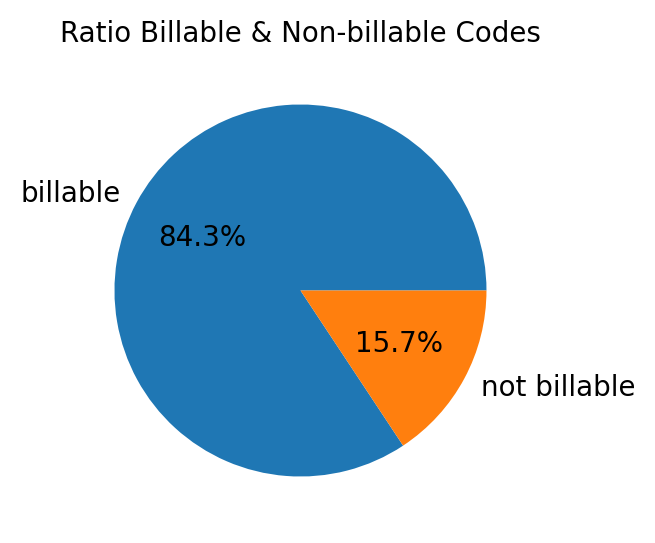

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(3,4), dpi=200)
plt.pie(icd10_hcc_pdf['icd_code_billable'].value_counts(), 
        labels = ["billable", "not billable"], 
        autopct = "%1.1f%%"
       )
plt.title("Ratio Billable & Non-billable Codes", size=10)
plt.show()

As we can see, some of the best matching codes are not billable. For such indications we can find codes that are relevant as well as billable

In [ ]:
icd10_oncology_mapping = {"C81-C96": "Malignant neoplasms of lymphoid, hematopoietic and related tissue",
                          "C76-C80": "Malignant neoplasms of ill-defined, other secondary and unspecified sites",
                          "D00-D09": "In situ neoplasms",
                          "C51-C58": "Malignant neoplasms of female genital organs",
                          "C43-C44": "Melanoma and other malignant neoplasms of skin",
                          "C15-C26": "Malignant neoplasms of digestive organs",
                          "C73-C75": "Malignant neoplasms of thyroid and other endocrine glands",
                          "D60-D64": "Aplastic and other anemias and other bone marrow failure syndromes",
                          "E70-E88": "Metabolic disorders",
                          "G89-G99": "Other disorders of the nervous system",
                          "R50-R69": "General symptoms and signs",
                          "R10-R19": "Symptoms and signs involving the digestive system and abdomen",
                          "Z00-Z13": "Persons encountering health services for examinations"}


def map_to_parent(x):
    charcode = x[0].lower()
    numcodes = int(x[1])
    
    for k, v in icd10_oncology_mapping.items():
        
        lower, upper = k.split('-')
        
        if charcode >= lower[0].lower() and numcodes >= int(lower[1]):
            
            if charcode < upper[0].lower():
                return v
            elif charcode == upper[0].lower() and numcodes <= int(upper[1]):
                return v

In [ ]:
icd10_hcc_pdf["onc_code_desc"] = icd10_hcc_pdf["icd10_code"].apply(map_to_parent).fillna("-")

In [ ]:
best_paid_icd_matches = []
indication_with_no_billable_icd = []

for i_, row in icd10_hcc_pdf.iterrows():
    if '1' not in row['billable']:
        indication_with_no_billable_icd.append([row['final_chunk'], 
                                      row['resolutions'][0], 
                                      row['all_codes'][0],
                                      row['billable'][0],
                                      row['hcc_score'][0],
                                      row['onc_code_desc'], 
                                      "-" ])
    else:
        n_zero_ind = list(row['billable']).index('1')
        best_paid_icd_matches.append([row['final_chunk'], 
                                      row['resolutions'][n_zero_ind], 
                                      row['all_codes'][n_zero_ind],
                                      row['billable'][n_zero_ind],
                                      row['hcc_score'][n_zero_ind],
                                      row['onc_code_desc'],
                                      n_zero_ind])

best_icd_mapped_pdf = pd.DataFrame(best_paid_icd_matches, columns=['ner_chunk', 'code_desc', 'code' , 'billable', 
                                             'corresponding_hcc_score', 'onc_code_desc', 'nearest_billable_code_pos'])
best_icd_mapped_pdf['corresponding_hcc_score'] = pd.to_numeric(best_icd_mapped_pdf['corresponding_hcc_score'], errors='coerce')

best_icd_mapped_pdf.head()

Out[42]:

,ner_chunk,code_desc,code,billable,corresponding_hcc_score,onc_code_desc,nearest_billable_code_pos
0,Mesothelioma,mesothelioma of pleura [Mesothelioma of pleura],C450,1,9.0,Melanoma and other malignant neoplasms of skin,1
1,Mesothelioma,mesothelioma of pleura [Mesothelioma of pleura],C450,1,9.0,Melanoma and other malignant neoplasms of skin,1
2,Mesothelioma,mesothelioma of pleura [Mesothelioma of pleura],C450,1,9.0,Melanoma and other malignant neoplasms of skin,1
3,cough,cough [Cough],R05,1,0.0,-,0
4,chest pain,chest pain [Pain in throat and chest],R074,1,0.0,-,0


**All chunks have been mapped to payable ICD codes**

In [ ]:
print(best_icd_mapped_pdf.billable.value_counts())

1 1497
Name: billable, dtype: int64

### Write `best_icd_mapped_df` to Delta
Now we can write the reimbursement-ready data with billable codes into a gold delta layer, which can be accessed for reporting and BI

In [ ]:
best_icd_mapped_df = spark.createDataFrame(best_icd_mapped_pdf)
best_icd_mapped_df.write.format('delta').mode('overwrite').save(f'{delta_path}/gold/best-icd-mapped')

/databricks/spark/python/pyspark/sql/pandas/conversion.py:499: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
 arrow_data = [[(c, t) for (_, c), t in zip(pdf_slice.iteritems(), arrow_types)]

In [ ]:
display(best_icd_mapped_df.limit(10))

ner_chunk,code_desc,code,billable,corresponding_hcc_score,onc_code_desc,nearest_billable_code_pos
Mesothelioma,mesothelioma of pleura [Mesothelioma of pleura],C450,1,9.0,Melanoma and other malignant neoplasms of skin,1
Mesothelioma,mesothelioma of pleura [Mesothelioma of pleura],C450,1,9.0,Melanoma and other malignant neoplasms of skin,1
Mesothelioma,mesothelioma of pleura [Mesothelioma of pleura],C450,1,9.0,Melanoma and other malignant neoplasms of skin,1
cough,cough [Cough],R05,1,0.0,-,0
chest pain,chest pain [Pain in throat and chest],R074,1,0.0,-,0
cough,cough [Cough],R05,1,0.0,-,0
chest pain,chest pain [Pain in throat and chest],R074,1,0.0,-,0
cancer,"cancer [Malignant (primary) neoplasm, unspecified]",C801,1,12.0,"Malignant neoplasms of lymphoid, hematopoietic and related tissue",0
numbness,numbness of skin [Paresthesia of skin],R202,1,0.0,-,0
tingling of her left arm,tingling sensation [Paresthesia of skin],R202,1,0.0,-,0


# 2. Get Drug codes from the notes

We will create a new pipeline to get drug codes. As NER model, we are using `ner_posology_large` and setting NerConverter's WhiteList `['DRUG']` in order to get only drug entities.

In [ ]:
## to get drugs
drugs_ner_ing = MedicalNerModel.pretrained("ner_posology_large", "en", "clinical/models") \
    .setInputCols(["sentence", "token", "embeddings"]) \
    .setOutputCol("ner_drug")\
    .setIncludeConfidence(False)

drugs_ner_converter_ing = NerConverterInternal() \
    .setInputCols(["sentence", "token", "ner_drug"]) \
    .setOutputCol("ner_chunk")\
    .setWhiteList(["DRUG"])
      
pipeline_rxnorm_ingredient = Pipeline(
    stages = [
        documentAssembler,
        sentenceDetector,
        tokenizer,
        word_embeddings,
        drugs_ner_ing,
        drugs_ner_converter_ing])

data_ner = spark.createDataFrame([['']]).toDF("text")
rxnorm_ner_model = pipeline_rxnorm_ingredient.fit(data_ner)

ner_posology_large download started this may take some time.
[ | ][OK!]

## Visualize Drug Entities

Now we will visualize a sample text with `NerVisualizer`.

`NerVisualizer` woks with LightPipeline, so we will create a `rxnorm_lp` with our `rxnorm_model`.

In [ ]:
rxnorm_ner_lp = LightPipeline(rxnorm_ner_model)

ann_text = rxnorm_ner_lp.fullAnnotate(sample_text.text)[0]
print(ann_text.keys())

dict_keys(['document', 'ner_chunk', 'token', 'ner_drug', 'embeddings', 'sentence'])

In [ ]:
#Creating the vizualizer 
from sparknlp_display import NerVisualizer

visualiser = NerVisualizer()

# Change color of an entity label
visualiser.set_label_colors({'DRUG':'#008080'})
ner_vis = visualiser.display(ann_text, label_col='ner_chunk',return_html=True)

#Displaying the vizualizer 
displayHTML(ner_vis)

Sample Type / Medical Specialty: Hematology - Oncology Sample Name: Discharge Summary - Mesothelioma - 1 Description: Mesothelioma, pleural effusion, atrial fibrillation, anemia, ascites, esophageal reflux, and history of deep venous thrombosis. (Medical Transcription Sample Report) PRINCIPAL DIAGNOSIS: Mesothelioma. SECONDARY DIAGNOSES: Pleural effusion, atrial fibrillation, anemia, ascites, esophageal reflux, and history of deep venous thrombosis. PROCEDURES 1. On August 24, 2007, decortication of the lung with pleural biopsy and transpleural fluoroscopy. 2. On August 20, 2007, thoracentesis. 3. On August 31, 2007, Port-A-Cath placement. HISTORY AND PHYSICAL: The patient is a 41-year-old Vietnamese female with a nonproductive cough that started last week. She has had right-sided chest pain radiating to her back with fever starting yesterday. She has a history of pericarditis and pericardectomy in May 2006 and developed cough with right-sided chest pain, and went to an urgent care center. Chest x-ray revealed right-sided pleural effusion. PAST MEDICAL HISTORY 1. Pericardectomy. 2. Pericarditis. 2. Atrial fibrillation. 4. RNCA with intracranial thrombolytic treatment. 5 PTA of MCA. 6. Mesenteric venous thrombosis. 7. Pericardial window. 8. Cholecystectomy. 9. Left thoracentesis. FAMILY HISTORY: No family history of coronary artery disease, CVA, diabetes, CHF or MI. The patient has one family member, a sister, with history of cancer. SOCIAL HISTORY: She is married. Employed with the US Post Office. She is a mother of three. Denies tobacco, alcohol or illicit drug use. MEDICATIONS 1. Coumadin DRUG 1 mg daily. Last INR was on Tuesday, August 14, 2007, and her INR was 2.3. 2. Amiodarone DRUG 100 mg p.o. daily. REVIEW OF SYSTEMS: Complete review of systems negative except as in pulmonary as noted above. The patient also reports occasional numbness and tingling of her left arm. PHYSICAL EXAMINATION VITAL SIGNS: Blood pressure 123/95, heart rate 83, respirations 20, temperature 97, and oxygen saturation 97%. GENERAL: Positive nonproductive cough and pain with coughing. HEENT: Pupils are equal and reactive to light and accommodation. Tympanic membranes are clear. NECK: Supple. No lymphadenopathy. No masses. RESPIRATORY: Pleural friction rub is noted. GI: Soft, nondistended, and nontender. Positive bowel sounds. No organomegaly. EXTREMITIES: No edema, no clubbing, no cyanosis, no tenderness. Full range of motion. Normal pulses in all extremities. SKIN: No breakdown or lesions. No ulcers. NEUROLOGIC: Grossly intact. No focal deficits. Awake, alert, and oriented to person, place, and time. LABORATORY DATA: Labs are pending. HOSPITAL COURSE: The patient was admitted for a right-sided pleural effusion for thoracentesis on Monday by Dr. X. Her Coumadin DRUG was placed on hold. A repeat echocardiogram was checked. She was started on prophylaxis for DVT with Lovenox DRUG 40 mg subcutaneously. Her history dated back to March 2005 when she first sought medical attention for evidence of pericarditis, which was treated with pericardial window in an outside hospital, at that time she was also found to have mesenteric pain and thrombosis, is now anticoagulated. Her pericardial fluid was accumulated and she was seen by Dr. Y. At that time, she was recommended for pericardectomy, which was performed by Dr. Z. Review of her CT scan from March 2006 prior to her pericardectomy, already shows bilateral plural effusions. The patient improved clinically after the pericardectomy with resolution of her symptoms. Recently, she was readmitted to the hospital with chest pain and found to have bilateral pleural effusion, the right greater than the left. CT of the chest also revealed a large mediastinal lymph node. We reviewed the pathology obtained from the pericardectomy in March 2006, which was diagnostic of mesothelioma. At this time, chest tube placement for drainage of the fluid occurred and thoracoscopy with fluid biopsies, which were performed, which reve

Now we will take rxnorm ner_chunks into a list for using in resolver pipeline

In [ ]:
rxnorm_code_res_df = rxnorm_ner_lp.transform(df) 

In [ ]:
rxnorm_code_res_pdf = rxnorm_code_res_df.select("path", F.explode(F.arrays_zip(rxnorm_code_res_df.ner_chunk.result, 
                                                                               rxnorm_code_res_df.ner_chunk.metadata)).alias("cols"))\
                                       .select("path", F.expr("cols['0']").alias("ner_chunk"), 
                                                       F.expr("cols['1']['entity']").alias("entity")).toPandas()

rxnorm_ner_chunks = list(rxnorm_code_res_pdf.ner_chunk)

We will create our resolver pipeline and get rxnorm codes of these ner_chunks.

In [ ]:
sbert_embedder = BertSentenceEmbeddings.pretrained("sbiobert_base_cased_mli", 'en', 'clinical/models')\
  .setInputCols(["ner_chunks"])\
  .setOutputCol("sentence_embeddings")

rxnorm_resolver = SentenceEntityResolverModel.pretrained("sbiobertresolve_rxnorm","en", "clinical/models")\
  .setInputCols(["sentence_embeddings"]) \
  .setOutputCol("rxnorm_code")\
  .setDistanceFunction("EUCLIDEAN")

rxnorm_pipelineModel = PipelineModel(stages=[
            documentAssemblerResolver,
            sbert_embedder,
            rxnorm_resolver
            ])

sbiobert_base_cased_mli download started this may take some time.
Approximate size to download 384.3 MB
[ | ][OK!]
sbiobertresolve_rxnorm download started this may take some time.
[ | ][ / ][ — ][ \ ][ | ][ / ][ — ][ \ ][ | ][ / ][ — ][ \ ][ | ][ / ][ — ][ \ ][ | ][ / ][ — ][OK!]

In [ ]:
rxnorm_resolver_lp = LightPipeline(rxnorm_pipelineModel)

In [ ]:
rxnorm_code_res = rxnorm_resolver_lp.fullAnnotate(rxnorm_ner_chunks)

We are selecting the columns which we need and convert to Pandas DataFrame. The values in `all_codes` and `resolitions` columns are seperated by ":::" and we are converting these columns to lists.

In [ ]:
tuples = []

for i in range(len(rxnorm_code_res)):
    for x,y in zip(rxnorm_code_res[i]["ner_chunks"], rxnorm_code_res[i]["rxnorm_code"]):
        tuples.append((rxnorm_code_res_pdf.path.iloc[i],x.result, y.result, y.metadata["confidence"], y.metadata["all_k_results"], y.metadata["all_k_resolutions"]))

rxnorm_res_cleaned_pdf = pd.DataFrame(tuples, columns=["path", "drug_chunk", "rxnorm_code", "confidence", "all_codes", "resolutions"])


codes = []
resolutions = []

for code, resolution in zip(rxnorm_res_cleaned_pdf['all_codes'], rxnorm_res_cleaned_pdf['resolutions']):
    
    codes.append(code.split(':::'))
    resolutions.append(resolution.split(':::'))
    
  
rxnorm_res_cleaned_pdf['all_codes'] = codes  
rxnorm_res_cleaned_pdf['resolutions'] = resolutions
rxnorm_res_cleaned_pdf['drugs'] = rxnorm_res_cleaned_pdf['resolutions'].apply(lambda x : x[0])

In [ ]:
display(rxnorm_res_cleaned_pdf)

/databricks/spark/python/pyspark/sql/pandas/conversion.py:499: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
 arrow_data = [[(c, t) for (_, c), t in zip(pdf_slice.iteritems(), arrow_types)]

path,drug_chunk,rxnorm_code,confidence,all_codes,resolutions,drugs
dbfs:/FileStore/HLS/nlp/data/mt_onc_50/mt_oncology_0.txt,Coumadin,202421,0.5329,"List(202421, 2898, 1855075, 216223, 216222, 218274, 152085, 128793, 2540, 1435932, 214904, 225235, 20136, 220822, 78903, 154, 1047076, 216087, 215960, 261472, 21732, 1370658, 215874, 215867, 202862)","List(coumadin, coumarin, coumaran, coricidin d, coricidin, medcodin, mycifradin, vicodin, cilastatin, reumacetin, a-cillin, celontin, camylofine, vicodin es, capreomycin, acenocoumarol, cydectin, cleocin hcl, cervidil, cenestin, cresatin, cocoate, capzasin-p, capitrol, cleocin)",coumadin
dbfs:/FileStore/HLS/nlp/data/mt_onc_50/mt_oncology_0.txt,Amiodarone,703,0.6925,"List(703, 544501, 1663223, 484718, 1151983, 1151982, 577358, 1663270, 203114, 1151981, 377132, 544503, 790892, 722, 832845, 620, 670596, 151347, 1000082, 18600, 203526, 17767, 720, 215194, 1440270)","List(amiodarone, aniodarone, amiodarone injection, aminodarone, amiodarone pill, amiodarone oral product, amiodarone powder, amiodarone injection [nexterone], amiodarone hydrochloride, amiodarone injectable product, amiodarone injectable solution, amiodarone injectable solution [aniodarone], amiodarone novaplus, amoxapine, amiodarone injectable solution [nexterone], amantadine, teva brand of amiodarone, amsidine, alcaftadine, azatadine, aramine, amlodipine, amodiaquine, alumadrine, amonafide)",amiodarone
dbfs:/FileStore/HLS/nlp/data/mt_onc_50/mt_oncology_0.txt,Coumadin,202421,0.5329,"List(202421, 2898, 1855075, 216223, 216222, 218274, 152085, 128793, 2540, 1435932, 214904, 225235, 20136, 220822, 78903, 154, 1047076, 216087, 215960, 261472, 21732, 1370658, 215874, 215867, 202862)","List(coumadin, coumarin, coumaran, coricidin d, coricidin, medcodin, mycifradin, vicodin, cilastatin, reumacetin, a-cillin, celontin, camylofine, vicodin es, capreomycin, acenocoumarol, cydectin, cleocin hcl, cervidil, cenestin, cresatin, cocoate, capzasin-p, capitrol, cleocin)",coumadin
dbfs:/FileStore/HLS/nlp/data/mt_onc_50/mt_oncology_0.txt,Lovenox,225036,0.0800,"List(225036, 542606, 224937, 540404, 1999683, 218173, 317261, 215354, 833136, 686430, 1363715, 2103170, 541368, 277489, 352424, 581512, 217961, 991208, 1538105, 216225, 1721450, 1598069, 853112, 6482, 352452)","List(lovenox, lutera, sanorex, lunesta, lutathera, magnalox, permirolast, anutone-hc, savella, lialda, eutanol g, lorbrena, santex la, lunelle, amitex la, loestrin fe, laniroif, naturetin, bravecto, cormax, estomaquil, soolantra, momordicae, ludiomil, avinza)",lovenox
dbfs:/FileStore/HLS/nlp/data/mt_onc_50/mt_oncology_0.txt,chemotherapy,215982,0.2013,"List(215982, 353612, 12574, 215984, 3041, 194000, 215978, 2555, 40048, 3639, 215703, 239, 15657, 636628, 1718999, 2236, 72962, 142433, 2541, 236234, 2396, 6851, 1148495, 1731354, 1363702)","List(chemdec, chemocycline, gemcitabine, chemet, cytarabine, capecitabine, chemdal, cisplatin, carboplatin, doxorubicin, blephamide, aclarubicin, decitabine, decitabine, gemcitabine injection, cephalothin, docetaxel, doxorubicin hydrochloride, cimetidine, gemcitabine hydrochloride, chlorothiazide, methotrexate, crizotinib, cytarabine injection, chlorothymol)",chemdec
dbfs:/FileStore/HLS/nlp/data/mt_onc_50/mt_oncology_0.txt,cisplatin,2555,0.9909,"List(2555, 1736853, 40048, 1152129, 1736856, 376433, 404931, 152200, 219265, 3639, 202852, 363065, 194000, 32592, 202856, 93789, 3041, 362545, 1156104, 12574, 239, 72834, 93790, 72962, 1733681)","List(cisplatin, cisplatin injection, carboplatin, cisplatin injectable product, cisplatin injection [platinol], cisplatin injectable solution, cisplatin novaplus, paraplatin, platinol-aq, doxorubicin, neoplatin, cisplatin injectable solution [platinex], capecitabine, oxaliplatin, platinol, cisplatin injectable solution [platinol], cytarabine, cisplatin injectable solution [platosin], carboplatin injectable product, gemcitabine, aclarubicin, cisplatin/cyclophosphamide/vindesine protocol, cisplatin injectable solutio

### Write `rxnorm_res_cleaned_df `to Delta

In [ ]:
rxnorm_res_cleaned_df = spark.createDataFrame(rxnorm_res_cleaned_pdf)
rxnorm_res_cleaned_df.write.format('delta').mode('overwrite').save(f'{delta_path}/gold/rxnorm-res-cleaned')

In [ ]:
display(rxnorm_res_cleaned_df.limit(10))

path,drug_chunk,rxnorm_code,confidence,all_codes,resolutions,drugs
dbfs:/FileStore/HLS/nlp/data/mt_onc_50/mt_oncology_0.txt,Coumadin,202421,0.5329,"List(202421, 2898, 1855075, 216223, 216222, 218274, 152085, 128793, 2540, 1435932, 214904, 225235, 20136, 220822, 78903, 154, 1047076, 216087, 215960, 261472, 21732, 1370658, 215874, 215867, 202862)","List(coumadin, coumarin, coumaran, coricidin d, coricidin, medcodin, mycifradin, vicodin, cilastatin, reumacetin, a-cillin, celontin, camylofine, vicodin es, capreomycin, acenocoumarol, cydectin, cleocin hcl, cervidil, cenestin, cresatin, cocoate, capzasin-p, capitrol, cleocin)",coumadin
dbfs:/FileStore/HLS/nlp/data/mt_onc_50/mt_oncology_0.txt,Amiodarone,703,0.6925,"List(703, 544501, 1663223, 484718, 1151983, 1151982, 577358, 1663270, 203114, 1151981, 377132, 544503, 790892, 722, 832845, 620, 670596, 151347, 1000082, 18600, 203526, 17767, 720, 215194, 1440270)","List(amiodarone, aniodarone, amiodarone injection, aminodarone, amiodarone pill, amiodarone oral product, amiodarone powder, amiodarone injection [nexterone], amiodarone hydrochloride, amiodarone injectable product, amiodarone injectable solution, amiodarone injectable solution [aniodarone], amiodarone novaplus, amoxapine, amiodarone injectable solution [nexterone], amantadine, teva brand of amiodarone, amsidine, alcaftadine, azatadine, aramine, amlodipine, amodiaquine, alumadrine, amonafide)",amiodarone
dbfs:/FileStore/HLS/nlp/data/mt_onc_50/mt_oncology_0.txt,Coumadin,202421,0.5329,"List(202421, 2898, 1855075, 216223, 216222, 218274, 152085, 128793, 2540, 1435932, 214904, 225235, 20136, 220822, 78903, 154, 1047076, 216087, 215960, 261472, 21732, 1370658, 215874, 215867, 202862)","List(coumadin, coumarin, coumaran, coricidin d, coricidin, medcodin, mycifradin, vicodin, cilastatin, reumacetin, a-cillin, celontin, camylofine, vicodin es, capreomycin, acenocoumarol, cydectin, cleocin hcl, cervidil, cenestin, cresatin, cocoate, capzasin-p, capitrol, cleocin)",coumadin
dbfs:/FileStore/HLS/nlp/data/mt_onc_50/mt_oncology_0.txt,Lovenox,225036,0.0800,"List(225036, 542606, 224937, 540404, 1999683, 218173, 317261, 215354, 833136, 686430, 1363715, 2103170, 541368, 277489, 352424, 581512, 217961, 991208, 1538105, 216225, 1721450, 1598069, 853112, 6482, 352452)","List(lovenox, lutera, sanorex, lunesta, lutathera, magnalox, permirolast, anutone-hc, savella, lialda, eutanol g, lorbrena, santex la, lunelle, amitex la, loestrin fe, laniroif, naturetin, bravecto, cormax, estomaquil, soolantra, momordicae, ludiomil, avinza)",lovenox
dbfs:/FileStore/HLS/nlp/data/mt_onc_50/mt_oncology_0.txt,chemotherapy,215982,0.2013,"List(215982, 353612, 12574, 215984, 3041, 194000, 215978, 2555, 40048, 3639, 215703, 239, 15657, 636628, 1718999, 2236, 72962, 142433, 2541, 236234, 2396, 6851, 1148495, 1731354, 1363702)","List(chemdec, chemocycline, gemcitabine, chemet, cytarabine, capecitabine, chemdal, cisplatin, carboplatin, doxorubicin, blephamide, aclarubicin, decitabine, decitabine, gemcitabine injection, cephalothin, docetaxel, doxorubicin hydrochloride, cimetidine, gemcitabine hydrochloride, chlorothiazide, methotrexate, crizotinib, cytarabine injection, chlorothymol)",chemdec
dbfs:/FileStore/HLS/nlp/data/mt_onc_50/mt_oncology_0.txt,cisplatin,2555,0.9909,"List(2555, 1736853, 40048, 1152129, 1736856, 376433, 404931, 152200, 219265, 3639, 202852, 363065, 194000, 32592, 202856, 93789, 3041, 362545, 1156104, 12574, 239, 72834, 93790, 72962, 1733681)","List(cisplatin, cisplatin injection, carboplatin, cisplatin injectable product, cisplatin injection [platinol], cisplatin injectable solution, cisplatin novaplus, paraplatin, platinol-aq, doxorubicin, neoplatin, cisplatin injectable solution [platinex], capecitabine, oxaliplatin, platinol, cisplatin injectable solution [platinol], cytarabine, cisplatin injectable solution [platosin], carboplatin injectable product, gemcitabine, aclarubicin, cisplatin/cyclophosphamide/vindesine protocol, cisplatin injectable solutio

Checking all posology entities `DRUG`, `FREQUENCY`, `DURATION`, `STRENGTH`, `FORM`, `DOSAGE` and `ROUTE` and their RXNORM Code by using `ner_posology_greedy` model without WhiteList.

In [ ]:
## to get drugs
drugs_ner_greedy = MedicalNerModel.pretrained("ner_posology_greedy", "en", "clinical/models") \
    .setInputCols(["sentence", "token", "embeddings"]) \
    .setOutputCol("ner_drug")\
    .setIncludeConfidence(False)

drugs_ner_converter_ing = NerConverterInternal() \
    .setInputCols(["sentence", "token", "ner_drug"]) \
    .setOutputCol("ner_chunk")

    
pipeline_rxnorm_greedy = Pipeline(
    stages = [
        documentAssembler,
        sentenceDetector,
        tokenizer,
        word_embeddings,
        drugs_ner_greedy,
        drugs_ner_converter_ing])

data_ner = spark.createDataFrame([['']]).toDF("text")
rxnorm_model_greedy = pipeline_rxnorm_greedy.fit(data_ner)

ner_posology_greedy download started this may take some time.
[ | ][OK!]

Visualize Greedy Algorithm Entities

In [ ]:
# sample_text = df.limit(1).select("text").collect()[0]

rxnorm_greedy_lp = LightPipeline(rxnorm_model_greedy)

ann_text = rxnorm_greedy_lp.fullAnnotate(sample_text.text)[0]
print(ann_text.keys())

dict_keys(['document', 'ner_chunk', 'token', 'ner_drug', 'embeddings', 'sentence'])

In [ ]:
#Creating the vizualizer 
from sparknlp_display import NerVisualizer

visualiser = NerVisualizer()

# Change color of DRUG entity label
visualiser.set_label_colors({'DRUG':'#008080'})
ner_vis = visualiser.display(ann_text, label_col='ner_chunk',return_html=True)

#Displaying the vizualizer 
displayHTML(ner_vis)

Sample Type / Medical Specialty: Hematology - Oncology Sample Name: Discharge Summary - Mesothelioma - 1 Description: Mesothelioma, pleural effusion, atrial fibrillation, anemia, ascites, esophageal reflux, and history of deep venous thrombosis. (Medical Transcription Sample Report) PRINCIPAL DIAGNOSIS: Mesothelioma. SECONDARY DIAGNOSES: Pleural effusion, atrial fibrillation, anemia, ascites, esophageal reflux, and history of deep venous thrombosis. PROCEDURES 1. On August 24, 2007, decortication of the lung with pleural biopsy and transpleural fluoroscopy. 2. On August 20, 2007, thoracentesis. 3. On August 31, 2007, Port-A-Cath placement. HISTORY AND PHYSICAL: The patient is a 41-year-old Vietnamese female with a nonproductive cough that started last week. She has had right-sided chest pain radiating to her back with fever starting yesterday. She has a history of pericarditis and pericardectomy in May 2006 and developed cough with right-sided chest pain, and went to an urgent care center. Chest x-ray revealed right-sided pleural effusion. PAST MEDICAL HISTORY 1. Pericardectomy. 2. Pericarditis. 2. Atrial fibrillation. 4. RNCA with intracranial thrombolytic treatment. 5 PTA of MCA. 6. Mesenteric venous thrombosis. 7. Pericardial window. 8. Cholecystectomy. 9. Left thoracentesis. FAMILY HISTORY: No family history of coronary artery disease, CVA, diabetes, CHF or MI. The patient has one family member, a sister, with history of cancer. SOCIAL HISTORY: She is married. Employed with the US Post Office. She is a mother of three. Denies tobacco, alcohol or illicit drug use. MEDICATIONS 1. Coumadin 1 mg DRUG daily FREQUENCY . Last INR was on Tuesday, August 14, 2007, and her INR was 2.3. 2. Amiodarone 100 mg p.o DRUG . daily FREQUENCY . REVIEW OF SYSTEMS: Complete review of systems negative except as in pulmonary as noted above. The patient also reports occasional numbness and tingling of her left arm. PHYSICAL EXAMINATION VITAL SIGNS: Blood pressure 123/95, heart rate 83, respirations 20, temperature 97, and oxygen saturation 97%. GENERAL: Positive nonproductive cough and pain with coughing. HEENT: Pupils are equal and reactive to light and accommodation. Tympanic membranes are clear. NECK: Supple. No lymphadenopathy. No masses. RESPIRATORY: Pleural friction rub is noted. GI: Soft, nondistended, and nontender. Positive bowel sounds. No organomegaly. EXTREMITIES: No edema, no clubbing, no cyanosis, no tenderness. Full range of motion. Normal pulses in all extremities. SKIN: No breakdown or lesions. No ulcers. NEUROLOGIC: Grossly intact. No focal deficits. Awake, alert, and oriented to person, place, and time. LABORATORY DATA: Labs are pending. HOSPITAL COURSE: The patient was admitted for a right-sided pleural effusion for thoracentesis on Monday by Dr. X. Her Coumadin DRUG was placed on hold. A repeat echocardiogram was checked. She was started on prophylaxis for DVT with Lovenox 40 mg subcutaneously. Her history dated back to March 2005 when she first sought medical attention for evidence of pericarditis, which was treated with pericardial window in an outside hospital, at that time she was also found to have mesenteric pain and thrombosis, is now anticoagulated. Her pericardial fluid was accumulated and she was seen by Dr. Y. At that time, she was recommended for pericardectomy, which was performed by Dr. Z. Review of her CT scan from March 2006 prior to her pericardectomy, already shows bilateral plural effusions. The patient improved clinically after the pericardectomy with resolution of her symptoms. Recently, she was readmitted to the hospital with chest pain and found to have bilateral pleural effusion, the right greater than the left. CT of the chest also revealed a large mediastinal lymph node. We reviewed the pathology obtained from the pericardectomy in March 2006, which was diagnostic of mesothelioma. At this time, chest tube placement for drainage of the fluid occurred and thoracoscopy with fluid biopsies, which were per

Lets take our greedy chunks into rxnorm resolver to see what will change

In [ ]:
rxnorm_code_greedy_res_df = rxnorm_model_greedy.transform(df)

In [ ]:
rxnorm_code_greedy_res_pdf = rxnorm_code_greedy_res_df.select("path", F.explode(F.arrays_zip(rxnorm_code_greedy_res_df.ner_chunk.result, 
                                                               rxnorm_code_greedy_res_df.ner_chunk.metadata)).alias("cols"))\
                         .select("path", F.expr("cols['0']").alias("ner_chunk"), 
                                         F.expr("cols['1']['entity']").alias("entity")).toPandas()

rxnorm_ner_greedy_chunks = list(rxnorm_code_greedy_res_pdf.ner_chunk)

In [ ]:
sbert_embedder = BertSentenceEmbeddings.pretrained("sbiobert_base_cased_mli", 'en', 'clinical/models')\
  .setInputCols(["ner_chunks"])\
  .setOutputCol("sentence_embeddings")

rxnorm_resolver = SentenceEntityResolverModel.pretrained("sbiobertresolve_rxnorm","en", "clinical/models")\
  .setInputCols(["sentence_embeddings"]) \
  .setOutputCol("rxnorm_code")\
  .setDistanceFunction("EUCLIDEAN")

rxnorm_greedy_pipelineModel = PipelineModel(stages=[
            documentAssemblerResolver,
            sbert_embedder,
            rxnorm_resolver
            ])

sbiobert_base_cased_mli download started this may take some time.
Approximate size to download 384.3 MB
[ | ][OK!]
sbiobertresolve_rxnorm download started this may take some time.
[ | ][OK!]

In [ ]:
rxnorm_greedy_lp = LightPipeline(rxnorm_greedy_pipelineModel)

In [ ]:
rxnorm_greedy_code_res = rxnorm_greedy_lp.fullAnnotate(rxnorm_ner_greedy_chunks)

In [ ]:
tuples = []

for i in range(len(rxnorm_greedy_code_res)):
    for x,y in zip(rxnorm_greedy_code_res[i]["ner_chunks"], rxnorm_greedy_code_res[i]["rxnorm_code"]):
        tuples.append((rxnorm_code_greedy_res_pdf.path.iloc[i],x.result, y.result, y.metadata["confidence"], y.metadata["all_k_results"], y.metadata["all_k_resolutions"]))

rxnorm_greedy_res = pd.DataFrame(tuples, columns=["path", "drug_chunk", "rxnorm_code", "confidence", "all_codes", "resolutions"])


codes = []
resolutions = []

for code, resolution in zip(rxnorm_greedy_res['all_codes'], rxnorm_greedy_res['resolutions']):
    
    codes.append(code.split(':::'))
    resolutions.append(resolution.split(':::'))
    
  
rxnorm_greedy_res['all_codes'] = codes  
rxnorm_greedy_res['resolutions'] = resolutions
rxnorm_greedy_res['drugs'] = rxnorm_greedy_res['resolutions'].apply(lambda x : x[0])

In [ ]:
rxnorm_greedy_res.head(20)

Out[36]:

,path,drug_chunk,rxnorm_code,confidence,all_codes,resolutions,drugs
0,dbfs:/FileStore/HLS/nlp/data/mt_onc_50/mt_oncology_0.txt,Coumadin 1 mg,438737,0.2020,"[438737, 447086, 330877, 336400, 2168762, 437893, 350284, 636675, 333663, 452857, 637189, 331499...","[coumarin 1 mg, propinox 1 mg, acenocoumarol 1 mg, ipecac 1 mg, tesamorelin 1 mg, ethacridine 1 ...",coumarin 1 mg
1,dbfs:/FileStore/HLS/nlp/data/mt_onc_50/mt_oncology_0.txt,daily,216356,0.4904,"[216356, 216358, 216351, 864120, 1856425, 1166944, 151781, 540256, 1043260, 216357, 216377, 1020...","[dailyhist, dailyhist-d, daily hist, oxy daily wash, oxy daily defense, daily hist oral product,...",dailyhist
2,dbfs:/FileStore/HLS/nlp/data/mt_onc_50/mt_oncology_0.txt,Amiodarone 100 mg p.o,331043,0.1398,"[331043, 573992, 835955, 199597, 876015, 564695, 540542, 566587, 316329, 565346, 835957, 875937,...","[amiodarone 100 mg, amiodarone 100 mg [amidox], amiodarone hydrochloride 100 mg, amiodarone 100 ...",amiodarone 100 mg
3,dbfs:/FileStore/HLS/nlp/data/mt_onc_50/mt_oncology_0.txt,daily,216356,0.4904,"[216356, 216358, 216351, 864120, 1856425, 1166944, 151781, 540256, 1043260, 216357, 216377, 1020...","[dailyhist, dailyhist-d, daily hist, oxy daily wash, oxy daily defense, daily hist oral product,...",dailyhist
4,dbfs:/FileStore/HLS/nlp/data/mt_onc_50/mt_oncology_0.txt,Coumadin,202421,0.5329,"[202421, 2898, 1855075, 216223, 216222, 218274, 152085, 128793, 2540, 1435932, 214904, 225235, 2...","[coumadin, coumarin, coumaran, coricidin d, coricidin, medcodin, mycifradin, vicodin, cilastatin...",coumadin
5,dbfs:/FileStore/HLS/nlp/data/mt_onc_50/mt_oncology_0.txt,chemotherapy,215982,0.2013,"[215982, 353612, 12574, 215984, 3041, 194000, 215978, 2555, 40048, 3639, 215703, 239, 15657, 636...","[chemdec, chemocycline, gemcitabine, chemet, cytarabine, capecitabine, chemdal, cisplatin, carbo...",chemdec
6,dbfs:/FileStore/HLS/nlp/data/mt_onc_50/mt_oncology_0.txt,cisplatin 75 mg/centimeter,1424917,0.0856,"[1424917, 563200, 563198, 566457, 2049118, 1425229, 543973, 328246, 568134, 544194, 563760, 1424...","[dabrafenib 75 mg, cisplatin 25 mg [platosin], cisplatin 25 mg/ml [platinex], doxepin 75 mg [ada...",dabrafenib 75 mg
7,dbfs:/FileStore/HLS/nlp/data/mt_onc_50/mt_oncology_0.txt,109 mg IV piggyback,350269,0.1283,"[350269, 350542, 349115, 1356818, 349114, 1806950, 384812, 617350, 336403, 452649, 806389, 85674...","[sodium gluconate 1090 mg, doxycycline 109 mg, doxycycline 109 mg oral capsule, polysaccharide i...",sodium gluconate 1090 mg
8,dbfs:/FileStore/HLS/nlp/data/mt_onc_50/mt_oncology_0.txt,over 2 hours,546139,0.2705,"[546139, 216077, 1425414, 261537, 358690, 393180, 393037, 800205, 217678, 1243021, 882493, 11832...","[sudatuss 2 df, claritin-d 24 hour, super 2x, h 9600, sodium sulfate 2 x, oxygen 2 %, carbon dio...",sudatuss 2 df
9,dbfs:/FileStore/HLS/nlp/data/mt_onc_50/mt_oncology_0.txt,Alimta 500 mg/ centimeter squared equaling 730 mg IV piggyback,282566,0.0484,"[282566, 573118, 200003, 204577, 242666, 252092, 199219, 1144139, 209533, 213196, 566878, 900783...","[chromium 0.05 mg / garcinia cambogia preparation 500 mg oral tablet, sodium phenylbutyrate 500 ...",chromium 0.05 mg / garcinia cambogia preparation 500 mg oral tablet


### Write `rxnorm_code_greedy_res_df` to Delta

In [ ]:
rxnorm_code_greedy_res_df=spark.createDataFrame(rxnorm_code_greedy_res_pdf)
rxnorm_code_greedy_res_df.write.format('delta').save(f"{delta_path}/silver/rxnorm-code-greedy-res")

/databricks/spark/python/pyspark/sql/pandas/conversion.py:499: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
 arrow_data = [[(c, t) for (_, c), t in zip(pdf_slice.iteritems(), arrow_types)]

In [ ]:
display(rxnorm_code_greedy_res_df.limit(10))

path,ner_chunk,entity
dbfs:/FileStore/HLS/nlp/data/mt_onc_50/mt_oncology_0.txt,Coumadin 1 mg,DRUG
dbfs:/FileStore/HLS/nlp/data/mt_onc_50/mt_oncology_0.txt,daily,FREQUENCY
dbfs:/FileStore/HLS/nlp/data/mt_onc_50/mt_oncology_0.txt,Amiodarone 100 mg p.o,DRUG
dbfs:/FileStore/HLS/nlp/data/mt_onc_50/mt_oncology_0.txt,daily,FREQUENCY
dbfs:/FileStore/HLS/nlp/data/mt_onc_50/mt_oncology_0.txt,Coumadin,DRUG
dbfs:/FileStore/HLS/nlp/data/mt_onc_50/mt_oncology_0.txt,chemotherapy,DRUG
dbfs:/FileStore/HLS/nlp/data/mt_onc_50/mt_oncology_0.txt,cisplatin 75 mg/centimeter,DRUG
dbfs:/FileStore/HLS/nlp/data/mt_onc_50/mt_oncology_0.txt,109 mg IV piggyback,DRUG
dbfs:/FileStore/HLS/nlp/data/mt_onc_50/mt_oncology_0.txt,over 2 hours,DURATION
dbfs:/FileStore/HLS/nlp/data/mt_onc_50/mt_oncology_0.txt,Alimta 500 mg/ centimeter squared equaling 730 mg IV piggyback,DRUG


# 3. Get Timeline Using RE Models

We will create a relation extration model to identify temporal relationships among clinical events by using pretrained **RelationExtractionModel** `re_temporal_events_clinical`.

In [ ]:
pos_tagger = PerceptronModel.pretrained("pos_clinical", "en", "clinical/models") \
    .setInputCols(["sentence", "token"])\
    .setOutputCol("pos_tags")

events_ner_tagger = MedicalNerModel()\
    .pretrained("ner_events_clinical", "en", "clinical/models")\
    .setInputCols("sentence", "token", "embeddings")\
    .setOutputCol("ner_tags")\
    .setIncludeConfidence(False)

ner_chunker = NerConverterInternal()\
    .setInputCols(["sentence", "token", "ner_tags"])\
    .setOutputCol("ner_chunks")

dependency_parser = DependencyParserModel.pretrained("dependency_conllu", "en")\
    .setInputCols(["sentence", "pos_tags", "token"])\
    .setOutputCol("dependencies")

clinical_re_Model = RelationExtractionModel()\
    .pretrained("re_temporal_events_clinical", "en", 'clinical/models')\
    .setInputCols(["embeddings", "pos_tags", "ner_chunks", "dependencies"])\
    .setOutputCol("relations")\
    .setMaxSyntacticDistance(4)\
    .setPredictionThreshold(0.9)

pipeline = Pipeline(stages=[
  documentAssembler,
  sentenceDetector,
  tokenizer, 
  word_embeddings, 
  pos_tagger, 
  events_ner_tagger,
  ner_chunker,
  dependency_parser,
  clinical_re_Model
])

empty_data = spark.createDataFrame([[""]]).toDF("text")
model = pipeline.fit(empty_data)

pos_clinical download started this may take some time.
Approximate size to download 1.5 MB
[ | ][ / ][OK!]
ner_events_clinical download started this may take some time.
[ | ][ / ][ — ][OK!]
dependency_conllu download started this may take some time.
Approximate size to download 16.7 MB
[ | ][ / ][ — ][ \ ][ | ][ / ][ — ][OK!]
re_temporal_events_clinical download started this may take some time.
Approximate size to download 5.9 MB
[ | ][ / ][OK!]

In [ ]:
temporal_re_df = model.transform(df)

Now we write the results in our delta silver layer

In [ ]:
temporal_re_df_silver = temporal_re_df.select("path", F.explode(F.arrays_zip(temporal_re_df.relations.result,
                                                                             temporal_re_df.relations.metadata)).alias("cols"))\
                                  .select("path",
                                          F.expr("cols['0']").alias("relation"),
                                          F.expr("cols['1']['entity1']").alias('entity1'),
                                          F.expr("cols['1']['chunk1']").alias('chunk1'),
                                          F.expr("cols['1']['entity2']").alias('entity2'),
                                          F.expr("cols['1']['chunk2']").alias('chunk2'),
                                          F.expr("cols['1']['confidence']").alias('confidence')
                                         )

### Write `temporal_re_df_silver` Delta

In [ ]:
temporal_re_df_silver.write.format('delta').save(f"{delta_path}/silver/temporal-re")

# 4. Relations Between Body Parts and Procedures

We will create a relation extration model to identify relationships between body parts and problem entities by using pretrained **RelationExtractionModel** `re_bodypart_problem`.

In [ ]:
pos_tagger = PerceptronModel.pretrained("pos_clinical", "en", "clinical/models") \
    .setInputCols(["sentence", "token"])\
    .setOutputCol("pos_tags")

ner_tagger = MedicalNerModel() \
    .pretrained("ner_jsl_greedy", "en", "clinical/models") \
    .setInputCols(["sentence", "token", "embeddings"]) \
    .setOutputCol("ner_tags")\
    .setIncludeConfidence(False)

ner_converter = NerConverterInternal() \
    .setInputCols(["sentence", "token", "ner_tags"]) \
    .setOutputCol("ner_chunks_re")\
    .setWhiteList(['Internal_organ_or_component', 'Problem', 'Procedure'])

dependency_parser = DependencyParserModel() \
    .pretrained("dependency_conllu", "en") \
    .setInputCols(["sentence", "pos_tags", "token"]) \
    .setOutputCol("dependencies")

re_model = RelationExtractionModel()\
    .pretrained('re_bodypart_problem', 'en', "clinical/models") \
    .setPredictionThreshold(0.5)\
    .setInputCols(["embeddings", "pos_tags", "ner_chunks_re", "dependencies"]) \
    .setOutputCol("relations")

bodypart_re_pipeline = Pipeline(stages=[documentAssembler, 
                            sentenceDetector, 
                            tokenizer, 
                            pos_tagger, 
                            word_embeddings, 
                            ner_tagger, 
                            ner_converter,
                            dependency_parser, 
                            re_model])


empty_data = spark.createDataFrame([['']]).toDF("text")
bodypart_re_model = bodypart_re_pipeline.fit(empty_data)

In [ ]:
bodypart_re_df = bodypart_re_model.transform(df)

In [ ]:
bodypart_re_df = bodypart_re_df.select("path", F.explode(F.arrays_zip(bodypart_re_df.relations.result, 
                                                                      bodypart_re_df.relations.metadata)).alias("cols"))\
                                .select("path",
                                        F.expr("cols['0']").alias("relation"),
                                        F.expr("cols['1']['entity1']").alias('entity1'),
                                        F.expr("cols['1']['chunk1']").alias('chunk1'),
                                        F.expr("cols['1']['entity2']").alias('entity2'),
                                        F.expr("cols['1']['chunk2']").alias('chunk2'),
                                        F.expr("cols['1']['confidence']").alias('confidence')
                                        )

### Write `bodypart_re_df` to Delta

In [ ]:
bodypart_re_df.write.format('delta').save(f'{delta_path}/silver/bodypart-relationships')

In [ ]:
display(bodypart_re_df.limit(10))

path,relation,entity1,chunk1,entity2,chunk2,confidence
dbfs:/FileStore/HLS/nlp/data/mt_onc_50/mt_oncology_0.txt,1,Procedure,decortication of the lung,Procedure,pleural biopsy,0.9999919
dbfs:/FileStore/HLS/nlp/data/mt_onc_50/mt_oncology_0.txt,0,Procedure,pericardectomy,Procedure,pericardectomy,0.9264386
dbfs:/FileStore/HLS/nlp/data/mt_onc_50/mt_oncology_0.txt,1,Procedure,chest tube placement,Procedure,thoracoscopy,0.99982053
dbfs:/FileStore/HLS/nlp/data/mt_onc_50/mt_oncology_0.txt,0,Procedure,chest tube placement,Procedure,fluid biopsies,0.5048493
dbfs:/FileStore/HLS/nlp/data/mt_onc_50/mt_oncology_0.txt,1,Procedure,thoracoscopy,Procedure,fluid biopsies,1.0
dbfs:/FileStore/HLS/nlp/data/mt_onc_50/mt_oncology_0.txt,1,Internal_organ_or_component,pectoral,Internal_organ_or_component,intramammary lymph nodes,0.5477111
dbfs:/FileStore/HLS/nlp/data/mt_onc_50/mt_oncology_0.txt,0,Internal_organ_or_component,pectoral,Internal_organ_or_component,L4,0.9999999
dbfs:/FileStore/HLS/nlp/data/mt_onc_50/mt_oncology_0.txt,0,Internal_organ_or_component,intramammary lymph nodes,Internal_organ_or_component,L4,0.9942292
dbfs:/FileStore/HLS/nlp/data/mt_onc_50/mt_oncology_1.txt,0,Procedure,Excision of large basal cell carcinoma,Procedure,dorsal conjunctival flap,0.9885477
dbfs:/FileStore/HLS/nlp/data/mt_onc_50/mt_oncology_1.txt,0,Procedure,Excision of large basal cell carcinoma,Procedure,dorsal conjunctival flap,0.9999963


# 5. Get Procedure codes from notes

We will create a new pipeline to get procedure codes. As NER model, we are using `ner_jsl_greedy` and setting NerConverterInternal's WhiteList `['Procedure']` in order to get only drug entities.

In [ ]:
proc_ner = MedicalNerModel.pretrained("ner_jsl_greedy", "en", "clinical/models") \
    .setInputCols(["sentence", "token", "embeddings"]) \
    .setOutputCol("ner_proc")\
    .setIncludeConfidence(False)

proc_ner_converter = NerConverterInternal() \
    .setInputCols(["sentence", "token", "ner_proc"]) \
    .setOutputCol("ner_chunk")\
    .setWhiteList(['Procedure'])


bert_pipeline_cpt = Pipeline(
    stages = [
        documentAssembler,
        sentenceDetector,
        tokenizer,
        word_embeddings,
        proc_ner,
        proc_ner_converter])

empty_data = spark.createDataFrame([['']]).toDF("text")
cpt_model = bert_pipeline_cpt.fit(empty_data)

In [ ]:
cpt_code_res = cpt_model.transform(df) 

Now we will take the ner_chunks into a list to use in resolver pipeline

In [ ]:
cpt_ner_df = cpt_code_res.select("path", F.explode(F.arrays_zip(cpt_code_res.ner_chunk.result, 
                                                                cpt_code_res.ner_chunk.metadata)).alias("cols"))\
                         .select("path", F.expr("cols['0']").alias("ner_chunk"), 
                                         F.expr("cols['1']['entity']").alias("entity")).toPandas()

cpt_ner_chunks = list(cpt_ner_df.ner_chunk)

In [ ]:
sbert_embedder = BertSentenceEmbeddings.pretrained("sbiobert_base_cased_mli", 'en', 'clinical/models')\
  .setInputCols(["ner_chunks"])\
  .setOutputCol("sentence_embeddings")

cpt_resolver = SentenceEntityResolverModel.pretrained("sbiobertresolve_cpt","en", "clinical/models")\
  .setInputCols(["sentence_embeddings"]) \
  .setOutputCol("cpt_code")\
  .setDistanceFunction("EUCLIDEAN")

cpt_pipelineModel = PipelineModel(stages=[
            documentAssemblerResolver,
            sbert_embedder,
            cpt_resolver
            ])

sbiobert_base_cased_mli download started this may take some time.
Approximate size to download 384.3 MB
[ | ][OK!]
sbiobertresolve_cpt download started this may take some time.
[ | ][OK!]

In [ ]:
cpt_lp = LightPipeline(cpt_pipelineModel)

In [ ]:
cpt_code_res = cpt_lp.fullAnnotate(cpt_ner_chunks)

In [ ]:
tuples = []

for i in range(len(cpt_code_res)):
    for x,y in zip(cpt_code_res[i]["ner_chunks"], cpt_code_res[i]["cpt_code"]):
        tuples.append((cpt_ner_df.path.iloc[i],x.result, cpt_ner_df.entity.iloc[i], y.result, y.metadata["confidence"], y.metadata["all_k_results"], y.metadata["all_k_resolutions"]))

cpt_df = pd.DataFrame(tuples, columns=["path", "chunks", "entity", "cpt_code", "confidence", "all_codes", "resolutions"])



codes = []
resolutions = []

for code, resolution in zip(cpt_df['all_codes'], cpt_df['resolutions']):
    
    codes.append(code.split(':::'))
    resolutions.append(resolution.split(':::'))
    
  
cpt_df['all_codes'] = codes  
cpt_df['resolutions'] = resolutions
cpt_df['cpt'] = cpt_df['resolutions'].apply(lambda x : x[0])

In [ ]:
cpt_df.head()

Out[92]:

,path,chunks,entity,cpt_code,confidence,all_codes,resolutions,cpt
0,dbfs:/FileStore/HLS/nlp/data/mt_onc_50/mt_oncology_0.txt,decortication of the lung,Procedure,32100,0.1184,"[32100, 31592, 32440, 39200, 32220, 32225, 32651, 32151, 32320, 32110, 32445, 50280, 60280, 6474...","[Thoracotomy; with exploration, Cricotracheal resection, Removal of lung, pneumonectomy;, Resect...",Thoracotomy; with exploration
1,dbfs:/FileStore/HLS/nlp/data/mt_onc_50/mt_oncology_0.txt,pleural biopsy,Procedure,32609,0.8109,"[32609, 32607, 32608, 32100, 32124, 32096, 32320, 32097, 32960, 32310, 39200, 32151, 32200, 3265...","[Thoracoscopy; with biopsy(ies) of pleura, Thoracoscopy; with diagnostic biopsy(ies) of lung inf...",Thoracoscopy; with biopsy(ies) of pleura
2,dbfs:/FileStore/HLS/nlp/data/mt_onc_50/mt_oncology_0.txt,thoracentesis,Procedure,32100,0.2843,"[32100, 60500, 25927, 19316, 39200, 32609, 60505, 49426, 62223, 60280, 32960, 61304, 64746, 3954...","[Thoracotomy; with exploration, Parathyroidectomy or exploration of parathyroid(s), Transmetacar...",Thoracotomy; with exploration
3,dbfs:/FileStore/HLS/nlp/data/mt_onc_50/mt_oncology_0.txt,Port-A-Cath placement,Procedure,50290,0.0735,"[50290, 33722, 49426, 49419, 33020, 47610, 62225, 47715, 33404, 43800, 44650, 60500, 62194, 6222...","[Excision of perinephric cyst , Closure of aortico-left ventricular tunnel , Revision of peri...",Excision of perinephric cyst
4,dbfs:/FileStore/HLS/nlp/data/mt_onc_50/mt_oncology_0.txt,pericardectomy,Procedure,32320,0.2040,"[32320, 32310, 61305, 32100, 32440, 31420, 33050, 32445, 31592, 47600, 33020, 61524, 44950, 3137...","[Decortication and parietal pleurectomy, Pleurectomy, parietal (separate procedure), Craniectomy...",Decortication and parietal pleurectomy


## Write `cpt_df` to Delta

In [ ]:
cpt_df#cpt_df=spark.createDataFrame(cpt_df)
cpt_df_spark.write.format('delta').save(f"{delta_path}/silver/cpt")

# 6. Get Assertion Status of Cancer Entities

We will create a new pipeline to get assertion status of cancer entities procedure codes. As NER model, we are using `ner_jsl_greedy`.

In [ ]:
# Cancer
bionlp_ner = MedicalNerModel.pretrained("ner_bionlp", "en", "clinical/models") \
    .setInputCols(["sentence", "token", "embeddings"]) \
    .setOutputCol("bionlp_ner")\
    .setIncludeConfidence(False)

bionlp_ner_converter = NerConverterInternal() \
    .setInputCols(["sentence", "token", "bionlp_ner"]) \
    .setOutputCol("bionlp_ner_chunk")\
    .setWhiteList(["Cancer"])

# Clinical Terminology
jsl_ner = MedicalNerModel.pretrained("ner_jsl_greedy", "en", "clinical/models") \
    .setInputCols(["sentence", "token", "embeddings"]) \
    .setOutputCol("jsl_ner")\
    .setIncludeConfidence(False)

jsl_ner_converter = NerConverterInternal() \
    .setInputCols(["sentence", "token", "jsl_ner"]) \
    .setOutputCol("jsl_ner_chunk")\
    .setWhiteList(["Oncological", "Symptom"])

chunk_merger = ChunkMergeApproach()\
    .setInputCols('bionlp_ner_chunk', "jsl_ner_chunk")\
    .setOutputCol('final_ner_chunk')

cancer_assertion = AssertionDLModel.pretrained("assertion_dl", "en", "clinical/models") \
    .setInputCols(["sentence", "final_ner_chunk", "embeddings"]) \
    .setOutputCol("assertion")


assertion_pipeline = Pipeline(
    stages = base_stages+[
        bionlp_ner,
        bionlp_ner_converter,
        jsl_ner,
        jsl_ner_converter,
        chunk_merger,
        cancer_assertion
    ])
empty_data = spark.createDataFrame([['']]).toDF("text")
assertion_model = assertion_pipeline.fit(empty_data)

In [ ]:
assertion_res = assertion_model.transform(df)

In [ ]:
assertion_df = assertion_res.select("path", F.explode(F.arrays_zip(assertion_res.final_ner_chunk.result, 
                                                                   assertion_res.final_ner_chunk.metadata, 
                                                                   assertion_res.assertion.result)).alias("cols"))\
                            .select("path", F.expr("cols['0']").alias("chunk"),
                                            F.expr("cols['1']['entity']").alias("entity"),
                                            F.expr("cols['2']").alias("assertion"))

In [ ]:
assertion_df.head(10)

Out[109]: [Row(path='dbfs:/FileStore/HLS/nlp/data/mt_onc_50/mt_oncology_0.txt', chunk='Mesothelioma', entity='Oncological', assertion='present'),
 Row(path='dbfs:/FileStore/HLS/nlp/data/mt_onc_50/mt_oncology_0.txt', chunk='Mesothelioma', entity='Oncological', assertion='present'),
 Row(path='dbfs:/FileStore/HLS/nlp/data/mt_onc_50/mt_oncology_0.txt', chunk='Mesothelioma', entity='Oncological', assertion='associated_with_someone_else'),
 Row(path='dbfs:/FileStore/HLS/nlp/data/mt_onc_50/mt_oncology_0.txt', chunk='nonproductive cough', entity='Symptom', assertion='present'),
 Row(path='dbfs:/FileStore/HLS/nlp/data/mt_onc_50/mt_oncology_0.txt', chunk='chest pain', entity='Symptom', assertion='present'),
 Row(path='dbfs:/FileStore/HLS/nlp/data/mt_onc_50/mt_oncology_0.txt', chunk='cough', entity='Symptom', assertion='present'),
 Row(path='dbfs:/FileStore/HLS/nlp/data/mt_onc_50/mt_oncology_0.txt', chunk='chest pain', entity='Symptom', assertion='present'),
 Row(path='dbfs:/FileStore/HLS/nlp/data/mt_onc_50/mt_oncology_0.txt', chunk='cancer', entity='Cancer', assertion='associated_with_someone_else'),
 Row(path='dbfs:/FileStore/HLS/nlp/data/mt_onc_50/mt_oncology_0.txt', chunk='occasional numbness', entity='Symptom', assertion='present'),
 Row(path='dbfs:/FileStore/HLS/nlp/data/mt_onc_50/mt_oncology_0.txt', chunk='tingling of her left arm', entity='Symptom', assertion='present')]

### Write `assertion_df` to Delta

In [ ]:
assertion_df.write.format('delta').save(f'{delta_path}/silver/assertion')

## License
Copyright / License info of the notebook. Copyright [2021] the Notebook Authors.  The source in this notebook is provided subject to the [Apache 2.0 License](https://spdx.org/licenses/Apache-2.0.html).  All included or referenced third party libraries are subject to the licenses set forth below.

|Library Name|Library License|Library License URL|Library Source URL|
| :-: | :-:| :-: | :-:|
|Pandas |BSD 3-Clause License| https://github.com/pandas-dev/pandas/blob/master/LICENSE | https://github.com/pandas-dev/pandas|
|Numpy |BSD 3-Clause License| https://github.com/numpy/numpy/blob/main/LICENSE.txt | https://github.com/numpy/numpy|
|Apache Spark |Apache License 2.0| https://github.com/apache/spark/blob/master/LICENSE | https://github.com/apache/spark/tree/master/python/pyspark|
|Matplotlib | | https://github.com/matplotlib/matplotlib/blob/master/LICENSE/LICENSE | https://github.com/matplotlib/matplotlib|
|Seaborn |BSD 3-Clause | https://github.com/seaborn/seaborn/blob/master/LICENSE | https://github.com/seaborn/seaborn/|
|Spark NLP Display|Apache License 2.0|https://github.com/JohnSnowLabs/spark-nlp-display/blob/main/LICENSE|https://github.com/JohnSnowLabs/spark-nlp-display|
|Spark NLP |Apache License 2.0| https://github.com/JohnSnowLabs/spark-nlp/blob/master/LICENSE | https://github.com/JohnSnowLabs/spark-nlp|
|Spark NLP for Healthcare|[Proprietary license - John Snow Labs Inc.](https://www.johnsnowlabs.com/spark-nlp-health/) |NA|NA|


|Author|
|-|
|Databricks Inc.|
|John Snow Labs Inc.|

## Disclaimers
Databricks Inc. (“Databricks”) does not dispense medical, diagnosis, or treatment advice. This Solution Accelerator (“tool”) is for informational purposes only and may not be used as a substitute for professional medical advice, treatment, or diagnosis. This tool may not be used within Databricks to process Protected Health Information (“PHI”) as defined in the Health Insurance Portability and Accountability Act of 1996, unless you have executed with Databricks a contract that allows for processing PHI, an accompanying Business Associate Agreement (BAA), and are running this notebook within a HIPAA Account.  Please note that if you run this notebook within Azure Databricks, your contract with Microsoft applies.